In [75]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import math
import torch.nn.functional as F

import medmnist
from medmnist import INFO, Evaluator

In [76]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [77]:
import os
from torchvision.utils import save_image

sample_dir = 'samples'
os.makedirs(sample_dir, exist_ok=True)

# We first work on a 2D dataset with size 28x28

In [78]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 128
lr = 5e-5
image_size = 28 * 28

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [79]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor()
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)
z_dim = 32

# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [80]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /home/gorkem/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-

In [81]:
# visualization

train_dataset.montage(length=1)

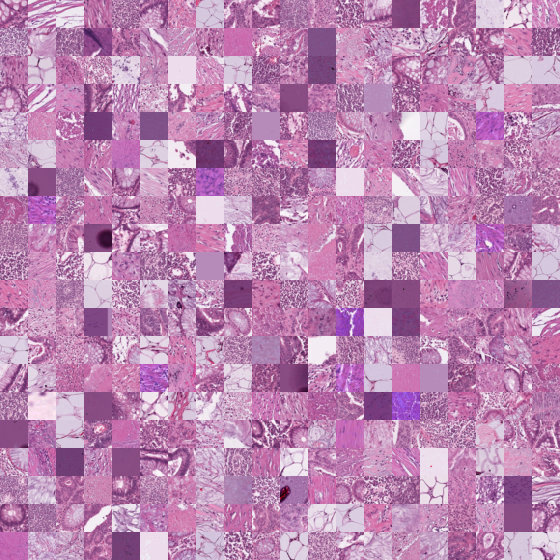

In [82]:
# montage

train_dataset.montage(length=20)

# Then, we define a basic VAE.

In [83]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [84]:
class UnFlatten(nn.Module):
    def forward(self, x):
        # Adjusted for 7x7 spatial dimensions, 128 channels
        return x.view(x.size(0), 128, 7, 7)

In [85]:
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch = z_mean.shape[0]
        dim = z_mean.shape[1]
        epsilon = torch.randn(batch, dim).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [86]:
# 2. Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(7 * 7 * 64, 1024)
        self.z_mean = nn.Linear(1024, latent_dim)
        self.z_log_var = nn.Linear(1024, latent_dim)
        self.sampling = Sampling()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

In [91]:
# 3. Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.dense = nn.Linear(latent_dim, 7 * 7 * 64)
        self.unflatten = nn.Unflatten(1, (64, 7, 7))
        self.conv_transpose1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        #self.conv_transpose2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv_transpose3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1)
        # Also change out_channels of the last conv_transpose layer to 3
        self.conv_transpose_output = nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.dense(x))
        x = self.unflatten(x)
        x = F.relu(self.bn1(self.conv_transpose1(x)))
        x = F.relu(self.bn2(self.conv_transpose2(x)))
        x = F.relu(self.conv_transpose3(x))
        decoder_outputs = torch.sigmoid(self.conv_transpose_output(x))
        return decoder_outputs

In [92]:
# 4. VAE Model
class VAE(nn.Module):
    def __init__(self, encoder, decoder, latent_dim=16):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

    def calculate_loss(self, data, reconstruction, z_mean, z_log_var, beta=1.0):
        # Reconstruction loss (Binary Cross-Entropy)
        reconstruction_loss = F.mse_loss(reconstruction, data, reduction='sum')
        reconstruction_loss = torch.sum(reconstruction_loss, dim=(1, 2, 3)) # Sum over H, W, C
        reconstruction_loss = torch.mean(reconstruction_loss) # Mean over batch

        # KL Divergence Loss
        # kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        # kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=1)
        kl_loss = torch.mean(kl_loss)

        total_loss = reconstruction_loss + beta * kl_loss
        return total_loss, reconstruction_loss, kl_loss

# Next, we can start to train and evaluate!

In [ ]:
# Device configuration
latent_dim = 128
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
vae = VAE(encoder, decoder, latent_dim=latent_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = vae.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [98]:
image_channels = 3

for epoch in range(NUM_EPOCHS):
    # Initialize accumulators for losses for the current epoch
    total_epoch_loss = 0.0
    total_epoch_reconst_loss = 0.0
    total_epoch_kl_loss = 0.0
    num_batches = 0

    kl_anneal_epochs = 100
    beta = min(1.0, epoch / kl_anneal_epochs)


    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)

        # Forward pass: model returns reconstructed output, mu, log_var
        x_reconst, mu, log_var = model(x)

        # --- Compute Reconstruction Loss (matching Keras) ---
        reconst_loss_per_element = F.binary_cross_entropy(x_reconst, x, reduction='none')
        reconst_loss_per_sample_channel = torch.sum(reconst_loss_per_element, dim=(2, 3))
        reconst_loss = torch.mean(reconst_loss_per_sample_channel)

        # --- Compute KL Divergence (matching Keras) ---
        kl_div_per_element = - 0.5 * (1 + log_var - mu.pow(2) - log_var.exp())
        kl_div_per_sample = torch.sum(kl_div_per_element, dim=1)
        kl_div = torch.mean(kl_div_per_sample)

        # --- Total Loss (matches Keras) ---
        loss = reconst_loss + beta * kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate losses for epoch-wise average printing
        total_epoch_loss += loss.item()
        total_epoch_reconst_loss += reconst_loss.item()
        total_epoch_kl_loss += kl_div.item()
        num_batches += 1

    # Calculate average losses for the epoch
    avg_total_loss = total_epoch_loss / num_batches
    avg_reconst_loss = total_epoch_reconst_loss / num_batches
    avg_kl_loss = total_epoch_kl_loss / num_batches

    # Print epoch-wise summary
    print ("Epoch[{}/{}], Avg Total Loss: {:.4f}, Avg Reconst Loss: {:.4f}, Avg KL Div: {:.4f} with Beta = {}"
           .format(epoch+1, NUM_EPOCHS, avg_total_loss, avg_reconst_loss, avg_kl_loss, beta))

    with torch.no_grad():
        num_samples_to_save = 10
        z_fixed = torch.randn(num_samples_to_save, model.latent_dim).to(device)
        out_sampled = model.decoder(z_fixed).view(-1, image_channels, 28, 28)
        save_image(out_sampled, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)), nrow=10)

        num_reconstruct_to_save = 10
        x_for_saving = next(iter(train_loader))[0][:num_reconstruct_to_save].to(device)

        out_reconst_for_save, _, _ = model(x_for_saving)

        x_concat_to_save = torch.cat([
            x_for_saving.view(-1, image_channels, 28, 28),
            out_reconst_for_save.view(-1, image_channels, 28, 28)
        ], dim=3)
        save_image(x_concat_to_save, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)), nrow=5)

Epoch[1/100], Avg Total Loss: 469.6514, Avg Reconst Loss: 469.6514, Avg KL Div: 2135.3289 with Beta = 0.0
Epoch[2/100], Avg Total Loss: 463.9548, Avg Reconst Loss: 461.4766, Avg KL Div: 247.8185 with Beta = 0.01
Epoch[3/100], Avg Total Loss: 463.5826, Avg Reconst Loss: 461.0704, Avg KL Div: 125.6128 with Beta = 0.02
Epoch[4/100], Avg Total Loss: 463.7494, Avg Reconst Loss: 461.0014, Avg KL Div: 91.6018 with Beta = 0.03
Epoch[5/100], Avg Total Loss: 463.9200, Avg Reconst Loss: 461.0547, Avg KL Div: 71.6338 with Beta = 0.04
Epoch[6/100], Avg Total Loss: 463.9804, Avg Reconst Loss: 461.0490, Avg KL Div: 58.6295 with Beta = 0.05
Epoch[7/100], Avg Total Loss: 464.1599, Avg Reconst Loss: 461.1930, Avg KL Div: 49.4483 with Beta = 0.06
Epoch[8/100], Avg Total Loss: 464.2196, Avg Reconst Loss: 461.2311, Avg KL Div: 42.6934 with Beta = 0.07
Epoch[9/100], Avg Total Loss: 464.3760, Avg Reconst Loss: 461.3570, Avg KL Div: 37.7372 with Beta = 0.08
Epoch[10/100], Avg Total Loss: 464.4890, Avg Reconst

KeyboardInterrupt: 

Displaying a Full Batch of Original Images in a Grid:


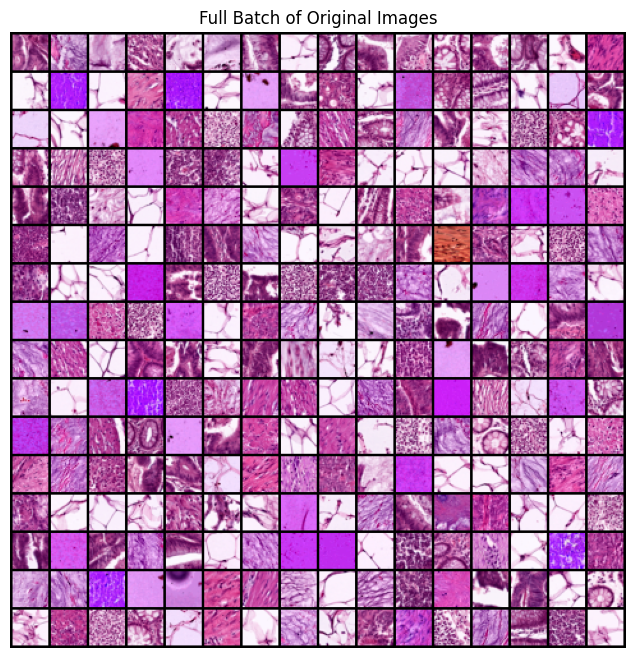


Displaying a Full Batch of Reconstructed Images in a Grid:


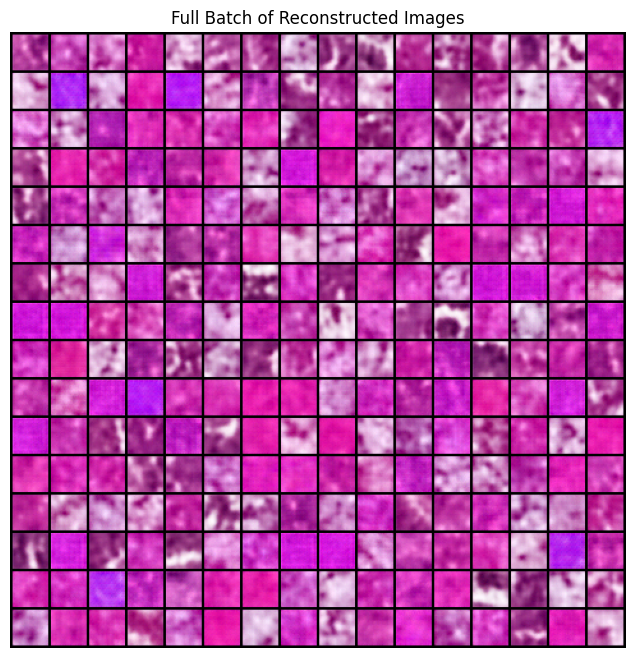


Displaying a Full Batch of Generated Images in a Grid:


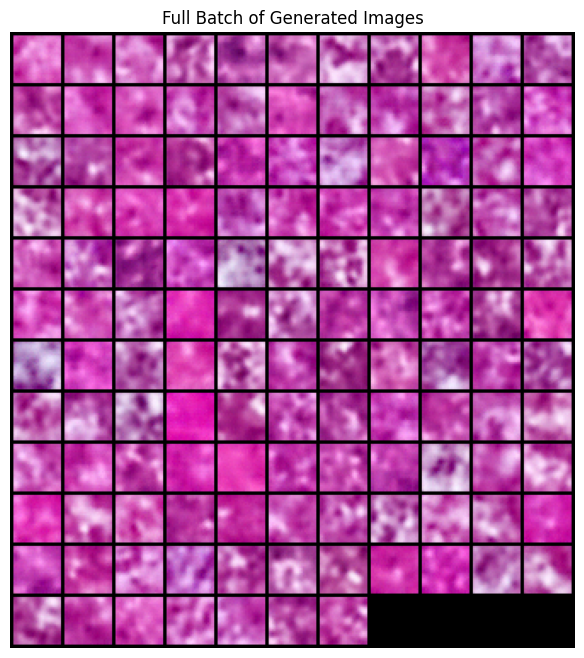

In [99]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow_tensor(img_tensor, title=None):
    """
    Displays a PyTorch image tensor.

    Args:
        img_tensor (torch.Tensor): The image tensor.
                                   Expected shape: (C, H, W) for single image
                                   or (N, C, H, W) for a batch.
                                   Assumes pixel values are in [0, 1] or can be normalized.
        title (str, optional): Title for the plot. Defaults to None.
    """
    # If it's a batch of images (4 dimensions: N, C, H, W), make a grid.
    if img_tensor.dim() == 4:
        # Determine nrow to make a somewhat square grid, or you can force it
        # For a full grid that's roughly square:
        num_images = img_tensor.shape[0]
        nrow = int(num_images**0.5) # Example: For 64 images, nrow will be 8
        if nrow == 0: nrow = 1 # Avoid division by zero for very small batches

        img_tensor = make_grid(img_tensor, nrow=nrow, normalize=True, scale_each=True)
        # normalize=True scales values to [0,1] for display, scale_each=True normalizes each image separately

    np_img = img_tensor.cpu().numpy()
    if np_img.ndim == 3 and np_img.shape[0] in [1, 3]: # Check for (C, H, W) format
        np_img = np.transpose(np_img, (1, 2, 0))
    if np_img.shape[-1] == 1: # For grayscale (H, W, 1) -> (H, W)
        np_img = np_img.squeeze(-1)

    plt.figure(figsize=(8, 8))
    plt.imshow(np_img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# --- How to display a full batch in a grid ---

# Get a full batch from your test_loader (or train_loader)
# Ensure test_loader and device are defined from your setup
# (e.g., as in the MedMNIST data loading example)

# Example: Get the first full batch of original images
x_batch, _ = next(iter(test_loader))
x_batch = x_batch.to(device)

print("Displaying a Full Batch of Original Images in a Grid:")
imshow_tensor(x_batch, title="Full Batch of Original Images")

# You can do the same for reconstructed images or generated samples if you have them in a batch:

# Example: Get a full batch of reconstructed images (assuming your model returns N, C, H, W or N, C, D, H, W)
# This assumes your model's forward pass gives you the correct output format
with torch.no_grad():
    reconstructed_batch, _, _ = model(x_batch) # Pass the full batch
    # Ensure it's in (N, C, H, W) format for make_grid, adjust view if needed for 3D -> 2D slices
    if reconstructed_batch.dim() == 5: # If your model outputs 3D (N, C, D, H, W)
        # You would need to select a slice to make it 2D for imshow_tensor
        # For simplicity, let's take a middle slice for all images in the batch
        middle_slice_idx = reconstructed_batch.shape[2] // 2 # Middle slice in depth
        reconstructed_batch_2d = reconstructed_batch[:, :, middle_slice_idx, :, :]
        print("\nDisplaying a Full Batch of Reconstructed Slices (middle depth) in a Grid:")
        imshow_tensor(reconstructed_batch_2d, title="Full Batch of Reconstructed Slices")
    else: # It's already 4D (N, C, H, W)
        print("\nDisplaying a Full Batch of Reconstructed Images in a Grid:")
        imshow_tensor(reconstructed_batch, title="Full Batch of Reconstructed Images")

# Example: Generate a full batch of new samples
with torch.no_grad():
    num_samples_to_generate = BATCH_SIZE # Generate as many as your batch size
    z_full_batch = torch.randn(num_samples_to_generate, model.latent_dim).to(device)
    generated_batch = model.decoder(z_full_batch)
    # Adjust view based on whether your decoder outputs 2D or 3D images
    if generated_batch.dim() == 5: # If 3D (N, C, D, H, W)
        middle_slice_idx = generated_batch.shape[2] // 2
        generated_batch_2d = generated_batch[:, :, middle_slice_idx, :, :]
        print("\nDisplaying a Full Batch of Generated Slices (middle depth) in a Grid:")
        imshow_tensor(generated_batch_2d, title="Full Batch of Generated Slices")
    else: # If 2D (N, C, H, W)
        print("\nDisplaying a Full Batch of Generated Images in a Grid:")
        imshow_tensor(generated_batch, title="Full Batch of Generated Images")